In [2]:
from time import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state

In [3]:
class SimulatedData:
    
    def __init__(self, X, t, y0, y1, y, uy=None, uc=None, ut=None):
        
        self.X = X
        self.t = t
        self.y0 = y0
        self.y1 = y1
        self.y = y
        self.uy = uy
        self.uc = uc
        self.ut = ut

class DataGenerator:

    def __init__(
        self, 
        n_features,
        uyct_mean=np.array([0, 0, 0]),
        uyct_cov=np.array([[1, 0, 0.5], [0, 1, 0.5], [0.5, 0.5, 1]]),
        coef_mean=np.array([0, 0, 0]),
        coef_cov=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
        noise_scale_x=0
    ):

        self.n_features = n_features
        self.uyct_mean = np.array(uyct_mean)
        self.uyct_cov = np.array(uyct_cov)
        self.coef_mean = np.array(coef_mean)
        self.coef_cov = np.array(coef_cov)
        self.noise_scale_x = noise_scale_x
        
    def reset_coef(self, seed=None):
        '''
        coef = [alpha, beta, gamma], represeting the coefficient of Uy, Uc and Ut for X respectively.
        '''

        random_state = check_random_state(seed)

        self.coef_ = random_state.multivariate_normal(
            mean=self.coef_mean, cov=self.coef_cov, size=self.n_features)   # (k, 3)


    def covariate(self, uy, uc, ut, noise_x):
        
        u_mat = np.c_[uy, uc, ut]      # (n, 3)
        ux = np.dot(u_mat, self.coef_.T)        # (n, k)
        X = 1 * (ux+noise_x>0)

        return X

    def generate_data(self, n, seed=None):

        random_state = check_random_state(seed)

        k = self.n_features

        uy, uc, ut = random_state.multivariate_normal(
            mean=self.uyct_mean, cov=self.uyct_cov, size=n).T

        # covariate
        noise_x = random_state.normal(0, self.noise_scale_x, size=(n, k))
        X = self.covariate(uy, uc, ut, noise_x)
        
        # treatment
        t = np.where(ut>0, 1, 0)

        # observed outcome
        y0 = np.where(uy>0, 1, 0)
        y1 = np.where(uy+uc>0, 1, 0)
        y = (1-t)*y0 + t*y1

        data = SimulatedData(X=X, t=t, y0=y0, y1=y1, y=y, uy=uy, uc=uc, ut=ut)

        return data
    
def dgp_stats(dg, n, is_exp=None, seed=None):
    
    k = dg.n_features
    if is_exp is None:
        data = dg.generate_data(n=n, seed=seed)
    else:
        data = dg.generate_data(n=n, is_exp=is_exp, seed=seed)
    feat_names = [f"x{i}" for i in range(k)]
    df = pd.DataFrame(
        data=np.c_[data.X, data.t, data.y0, data.y1, data.y, data.uy, data.uc, data.ut], 
        columns=feat_names+['t', 'y0', 'y1', 'y', 'uy', 'uc', 'ut'])
    
    mask = (data.t == 1)

    agg_operations = {'uy': 'mean', 'uc': 'mean', 'ut': 'mean', 
                      't': 'mean', 'y1': 'mean', 'y0': 'mean'}

    stats = df.groupby(feat_names).agg(agg_operations)
    stats = stats.rename(columns={'uy': 'cauy', 'uc': 'cauc', 'ut': 'caut', 
                          't': 'cat', 'y1': 'cay1', 'y0': 'cay0'})

    stats['cate'] = stats.cay1 - stats.cay0

    stats['cayt'] = df[mask].groupby(feat_names)['y'].mean()
    stats['cayc'] = df[~mask].groupby(feat_names)['y'].mean()

    stats['cate_est'] = stats.cayt - stats.cayc
    stats['bias'] = stats.cate_est - stats.cate
    
    return stats

In [4]:
k = 8
dg = DataGenerator(
    n_features=k,
    uyct_mean=[0, 0, 0],
    uyct_cov=[[1, 0, 0.5], [0, 1, 0.5], [0.5, 0.5, 1]],
    coef_mean=[0, 0, 0],
    coef_cov=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    noise_scale_x=1
)

dg.reset_coef()

In [5]:
def scatter_plot(x, y, x_name, y_name, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.scatter(x, y, s=12)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    

Assuming $U_y$ and $U_c$ are independent, how do $U_y$ and $U_c$ affect true CATE? 

For this, two cases are discussed: (1) $X$ is only related to $U_y$; (2) $X$ is only related to $U_c$.

$X$ is related to $U_y$. 

```
Uy  Uc  Ut
 |
 X
```

When $U_c$ is constant,
- $U_c<0$: As $U_c$ increases, the relationship between CATE and $E[U_y|X]$ transitions from a decreasing function to a concave up function.
- $U_c>0$: As $U_c$ increases, the relationship between CATE and $E[U_y|X]$ transitions from a concave down function to a decreasing function.

When $U_c=0.1$ and $Var(U_c)\neq 0$, the relationship between CATE and $E[U_y|X]$ is first concave downward and then turns concave upward.


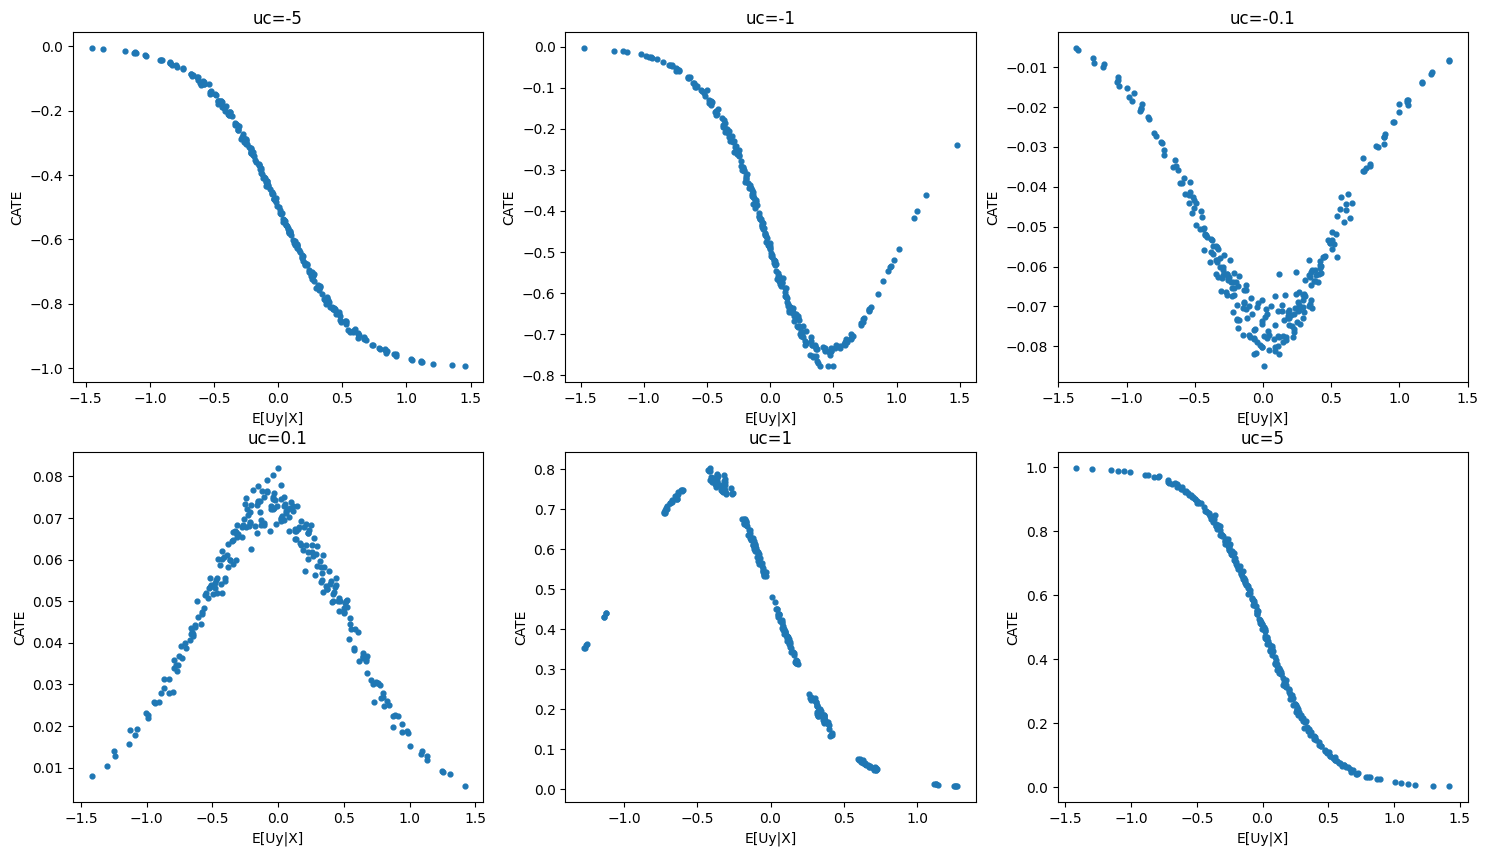

In [6]:
dg.uyct_mean=[0.0, 0, 0]
dg.uyct_cov = [
    [1, 0, 0], 
    [0, 0, 0], 
    [0, 0, 1]
]
dg.coef_cov = [[1, 0, 0], [0, 0, 0], [0, 0, 0]]

uc_mean_grid = [-5, -1, -0.1, 0.1, 1, 5]

fig, ax = plt.subplots(2, 3, figsize=(18, 10))

for i, uc_mean in enumerate(uc_mean_grid):
    
    r, c = i//3, i%3

    dg.uyct_mean[1] = uc_mean
    dg.reset_coef()
    stats = dgp_stats(dg, n=2000000)
    scatter_plot(stats['cauy'], stats['cate'], 'E[Uy|X]', 'CATE', ax[r][c])
    ax[r][c].set_title(f"uc={uc_mean}")
    
plt.show()

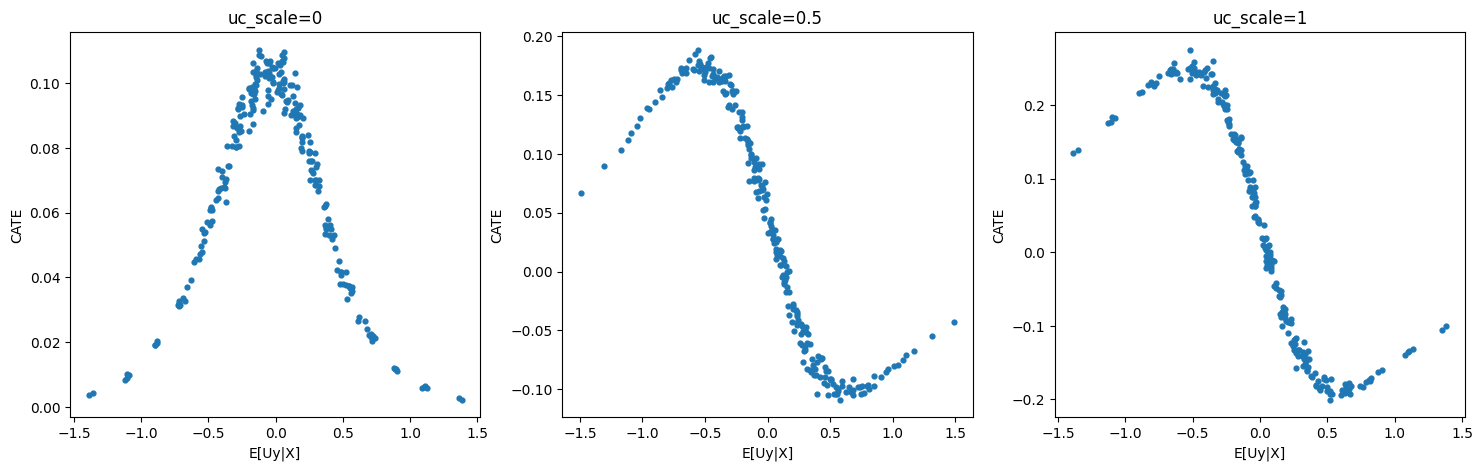

In [7]:
dg.uyct_mean=[0.0, 0.1, 0]
dg.uyct_cov = [
    [1, 0, 0], 
    [0, 1, 0], 
    [0, 0, 1]
]
dg.coef_cov = [[1, 0, 0], [0, 0, 0], [0, 0, 0]]

uc_scale_grid = [0, 0.5, 1]

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, uc_scale in enumerate(uc_scale_grid):

    dg.uyct_cov[1][1] = uc_scale
    dg.reset_coef()
    stats = dgp_stats(dg, n=2000000)
    scatter_plot(stats['cauy'], stats['cate'], 'E[Uy|X]', 'CATE', ax[i])
    ax[i].set_title(f"uc_scale={uc_scale}")
    
plt.show()

$X$ is related to $U_c$. 
```
Uy  Uc  Ut
     |
     X
```
- Larger $E[U_c|X]$, larger CATE.
- As the variance of $U_c$ increases, the relationship between CATE and $E[U_c|X]$ shifts from a S-shaped cruve to an almost linear curve.



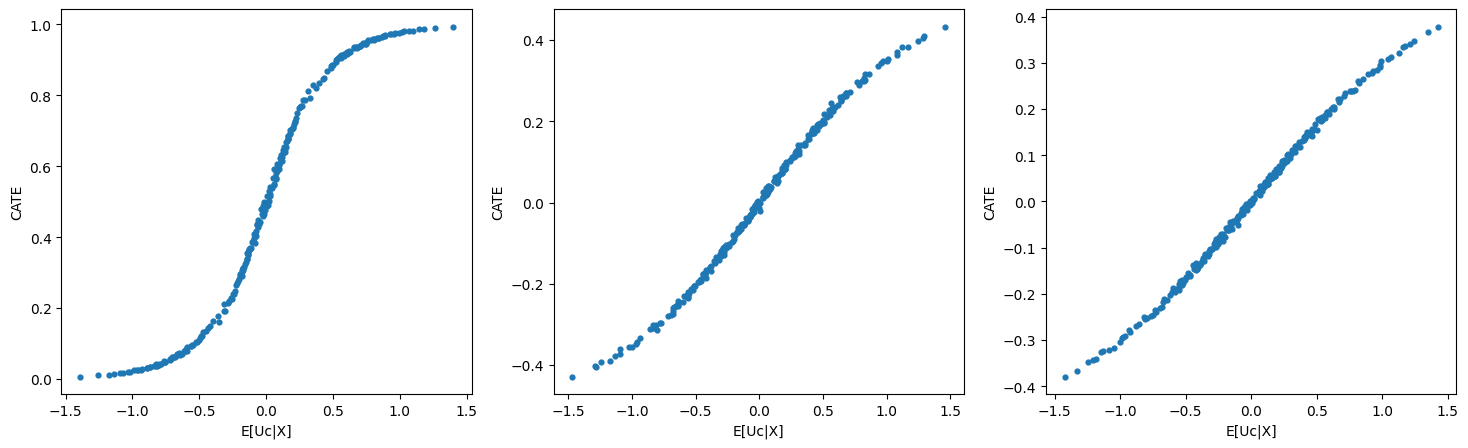

In [8]:
dg.uyct_mean=[0.0, 0.0, 0]
dg.uyct_cov = [
    [1, 0, 0], 
    [0, 1, 0], 
    [0, 0, 1]
]
dg.coef_cov = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]

uy_scale_grid = [0, 0.5, 1]

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, uy_scale in enumerate(uc_scale_grid):

    dg.uyct_cov[0][0] = uy_scale
    dg.reset_coef()
    stats = dgp_stats(dg, n=2000000)
    scatter_plot(stats['cauc'], stats['cate'], 'E[Uc|X]', 'CATE', ax[i])
    
plt.show()

How do different DGPs affect bias? Below are several DGPs.

If $U_t$ is independent of $U_y$ and $U_c$ given $X$, then there is no confounding bias.

```
  Ut

Uy  Uc
  \ /
   X
```

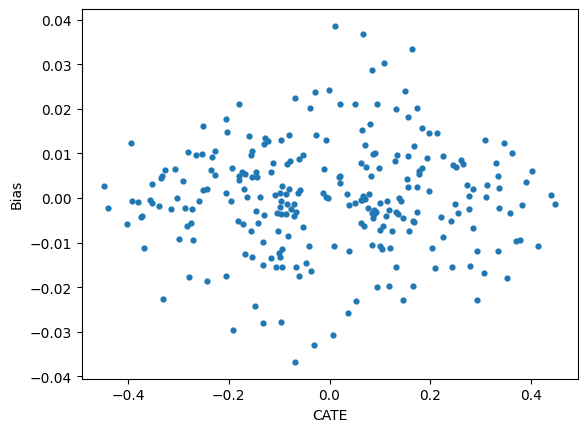

In [9]:
dg.uyct_mean=[0.0, 0.0, 0]
dg.uyct_cov = [
    [1, 0, 0], 
    [0, 1, 0], 
    [0, 0, 1]
]
dg.coef_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 0]]

dg.reset_coef()

stats = dgp_stats(dg,  n=2000000)

scatter_plot(stats['cate'], stats['bias'], 'CATE', 'Bias')

Before discussing the DGPs with the confounding bias, we illustrate how confounding bias is calculated.

True CATE: $E[Y^1|X]-E[Y^0|X]$;

Estimated CATE: $E[Y|T=1,X]-E[Y|T=0,X]$

Bias: $E[Y|T=1|X]-E[Y^1|X] + E[Y^0|X]-E[Y|T=0,X]$
- The first component $E[Y|T=1|X]-E[Y^1|X]=\frac{P(T=0|X)}{P(T=1|X)}\cdot\left(E[Y^1|X]-E[Y^1|T=0,X]\right)$;
- The second component, $E[Y^0|X]-E[Y|T=0,X]=\frac{P(T=1|X)}{P(T=0|X)}\cdot\left(E[Y^0|T=1,X]-E[Y^0|X]\right)$

The above is based on $E[Y^0|X]=P(T=1|X)\cdot E[Y^0|T=1,X]+P(T=0|X)\cdot E[Y^0|T=0,X]$, same for $E[Y^1|X]$.

Both $X$ and $U_t$ are related to $U_y$. Here we consider two cases: (1) $U_c$ is a fixed value; (2) The variance of $U_c$ is non-zero. 
```
Ut
 |
Uy  Uc
 |
 X
```

When $U_c$ is fixed, 
- Larger $E[U_y|X]$, larger $P(T=1|X)$;
- Larger $E[U_y|X]$, larger $E[Y_0|X]-E[Y|T=0,X]$, smaller $E[Y|T=1,X]-E[Y_1|X]$.
- Larger CATE, smaller bias.

In [10]:
start = time()

# Uc is a fixed value
dg.uyct_mean=[0.0, 0.1, 0]
dg.uyct_cov = [
    [1, 0, 1], 
    [0, 0, 0], 
    [1, 0, 1]
]
dg.coef_cov = [[1, 0, 0], [0, 0, 0], [0, 0, 0]]


dg.reset_coef()

repeat = 20
stats = dgp_stats(dg,  n=2000000, seed=0)
for i in range(1, repeat):
    stats += dgp_stats(dg,  n=2000000, seed=i)
stats /= repeat

print(f"Runtime={(time()-start):.3f}s")

Runtime=42.840s


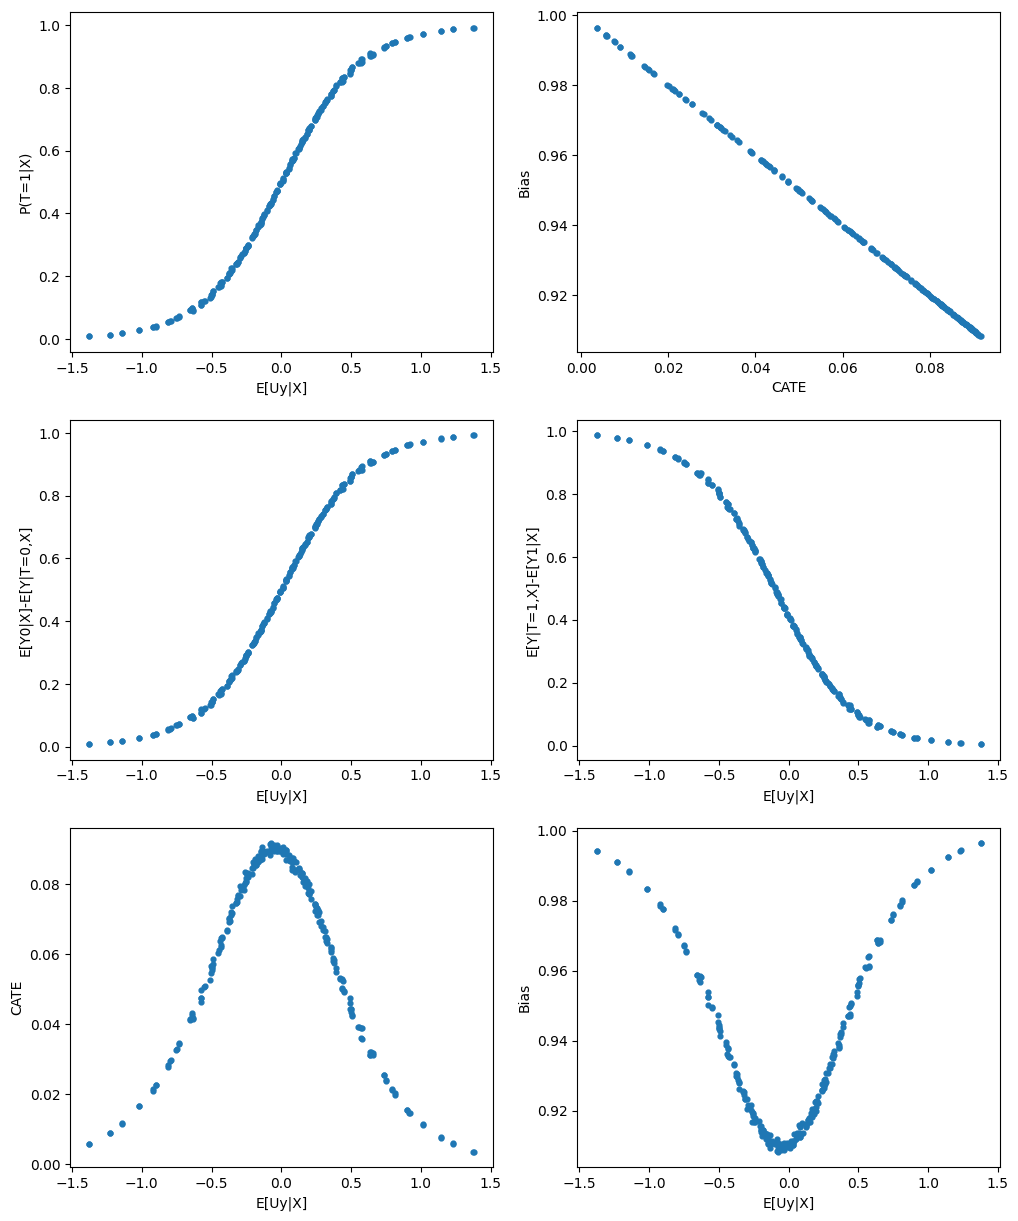

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))
scatter_plot(stats['cauy'], stats['cat'], 'E[Uy|X]', 'P(T=1|X)', ax[0][0])
scatter_plot(stats['cate'], stats['bias'], 'CATE', 'Bias', ax[0][1])
scatter_plot(stats['cauy'], stats['cay0']-stats['cayc'], 'E[Uy|X]', 'E[Y0|X]-E[Y|T=0,X]', ax[1][0])
scatter_plot(stats['cauy'], stats['cayt']-stats['cay1'], 'E[Uy|X]', 'E[Y|T=1,X]-E[Y1|X]', ax[1][1])
scatter_plot(stats['cauy'], stats['cate'], 'E[Uy|X]', 'CATE', ax[2][0])
scatter_plot(stats['cauy'], stats['bias'], 'E[Uy|X]', 'Bias', ax[2][1])

plt.show()

When the variance of $U_c$ is 1, 
- Larger $E[U_y|X]$, larger $P(T=1|X)$;
- Larger $E[U_y|X]$, larger $E[Y_0|X]-E[Y|T=0,X]$, smaller $E[Y|T=1,X]-E[Y_1|X]$.
- The relationship between bias and CATE is shown in the following second plot.

In [12]:
start = time()

# Uc has variations
dg.uyct_mean=[0.0, 0.0, 0]
dg.uyct_cov = [
    [1, 0, 1], 
    [0, 1, 0], 
    [1, 0, 1]
]
dg.coef_cov = [[1, 0, 0], [0, 0, 0], [0, 0, 0]]


dg.reset_coef()

repeat = 20
stats = dgp_stats(dg,  n=2000000, seed=0)
for i in range(1, repeat):
    stats += dgp_stats(dg,  n=2000000, seed=i)
stats /= repeat

print(f"Runtime={(time()-start):.3f}s")


Runtime=43.647s


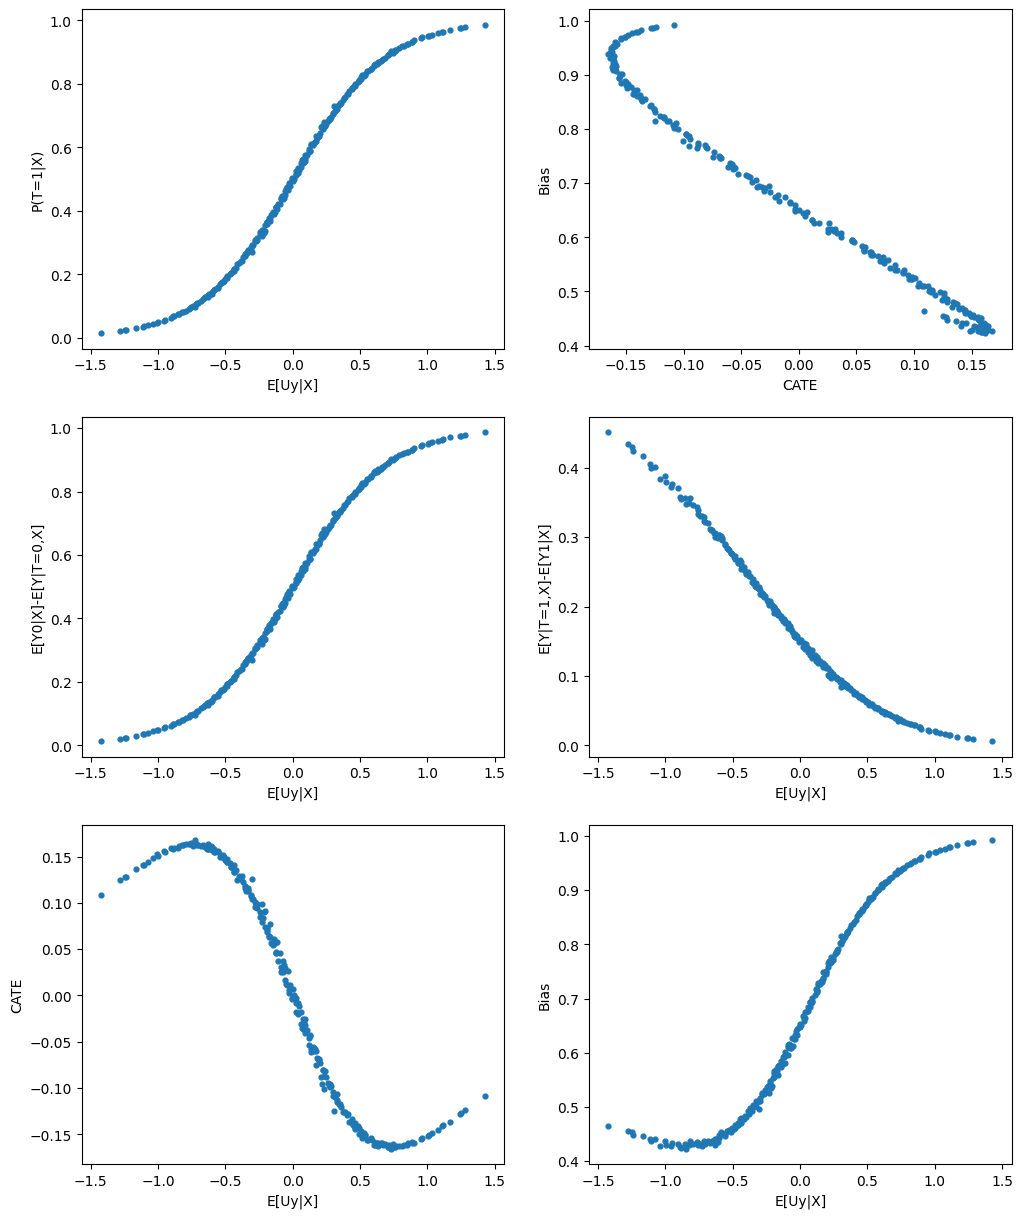

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))
scatter_plot(stats['cauy'], stats['cat'], 'E[Uy|X]', 'P(T=1|X)', ax[0][0])
scatter_plot(stats['cate'], stats['bias'], 'CATE', 'Bias', ax[0][1])
scatter_plot(stats['cauy'], stats['cay0']-stats['cayc'], 'E[Uy|X]', 'E[Y0|X]-E[Y|T=0,X]', ax[1][0])
scatter_plot(stats['cauy'], stats['cayt']-stats['cay1'], 'E[Uy|X]', 'E[Y|T=1,X]-E[Y1|X]', ax[1][1])
scatter_plot(stats['cauy'], stats['cate'], 'E[Uy|X]', 'CATE', ax[2][0])
scatter_plot(stats['cauy'], stats['bias'], 'E[Uy|X]', 'Bias', ax[2][1])

plt.show()

$X$ is related to $U_y$, $U_t$ is related to $U_c$.
```
    Ut
    |
Uy  Uc
 |
 X
```

- P(T=1|X) is close to 0.5 regardless of $X$.
- $E[Y^0|X]-E[Y|T=0,X]$ is close to 0 regardless of $X$.
- The relationship between $E[Y|T=1,X]-E[Y_1|X]$ and $E[U_y|X]$ is concave downward.
- The relationship between bias and CATE is shown in the following second plot.

In [14]:
start = time()

dg.uyct_mean=[0.0, 0.0, 0]
dg.uyct_cov = [
    [1, 0, 0], 
    [0, 1, 1], 
    [0, 1, 1]
]
dg.coef_cov = [[1, 0, 0], [0, 0, 0], [0, 0, 0]]

dg.reset_coef()

repeat = 20
stats = dgp_stats(dg,  n=2000000, seed=0)
for i in range(1, repeat):
    stats += dgp_stats(dg,  n=2000000, seed=i)
stats /= repeat

print(f"Runtime={(time()-start):.3f}s")


Runtime=44.389s


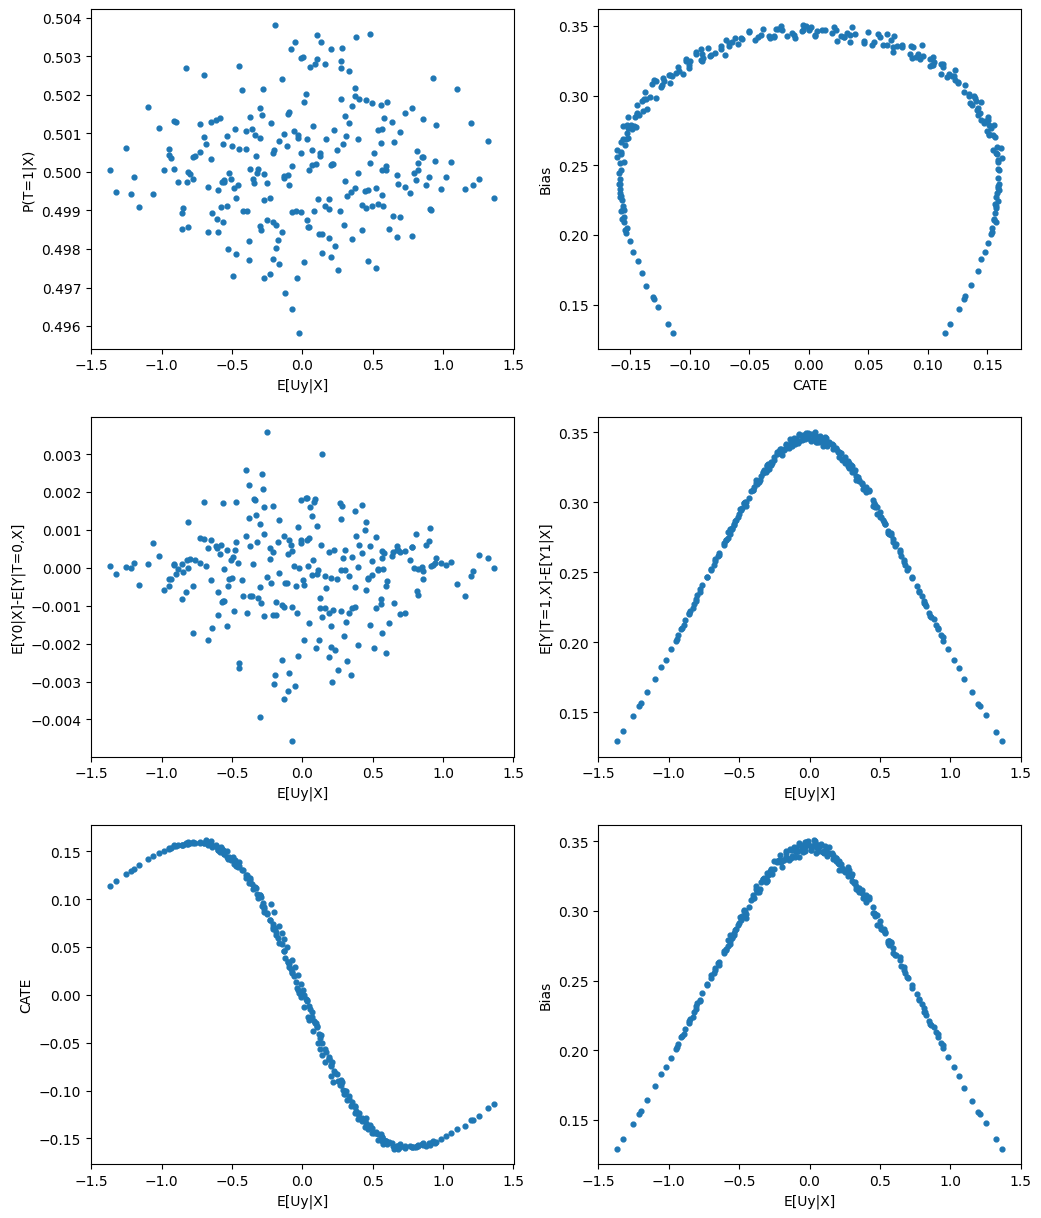

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))
scatter_plot(stats['cauy'], stats['cat'], 'E[Uy|X]', 'P(T=1|X)', ax[0][0])
scatter_plot(stats['cate'], stats['bias'], 'CATE', 'Bias', ax[0][1])
scatter_plot(stats['cauy'], stats['cay0']-stats['cayc'], 'E[Uy|X]', 'E[Y0|X]-E[Y|T=0,X]', ax[1][0])
scatter_plot(stats['cauy'], stats['cayt']-stats['cay1'], 'E[Uy|X]', 'E[Y|T=1,X]-E[Y1|X]', ax[1][1])
scatter_plot(stats['cauy'], stats['cate'], 'E[Uy|X]', 'CATE', ax[2][0])
scatter_plot(stats['cauy'], stats['bias'], 'E[Uy|X]', 'Bias', ax[2][1])

plt.show()

$X$ is related to $U_c$, $U_t$ is related to $U_y$.
```
Ut
 |
Uy  Uc
     |
     X
```

- P(T=1|X) is close to 0.5 regardless of $X$.
- $E[Y^0|X]-E[Y|T=0,X]$ remains unchanged regardless of $X$.
- The relationship between $E[Y|T=1,X]-E[Y_1|X]$ and $E[U_y|X]$ is concave downward.
- The relationship between bias and CATE is concave downward.


In [16]:
start = time()
dg.uyct_mean=[0.0, 0.0, 0]
dg.uyct_cov = [
    [1, 0, 1], 
    [0, 1, 0], 
    [1, 0, 1]
]
dg.coef_cov = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]


dg.reset_coef()

repeat = 20
stats = dgp_stats(dg,  n=2000000, seed=0)
for i in range(1, repeat):
    stats += dgp_stats(dg,  n=2000000, seed=i)
stats /= repeat

print(f"Runtime={(time()-start):.3f}s")

Runtime=46.291s


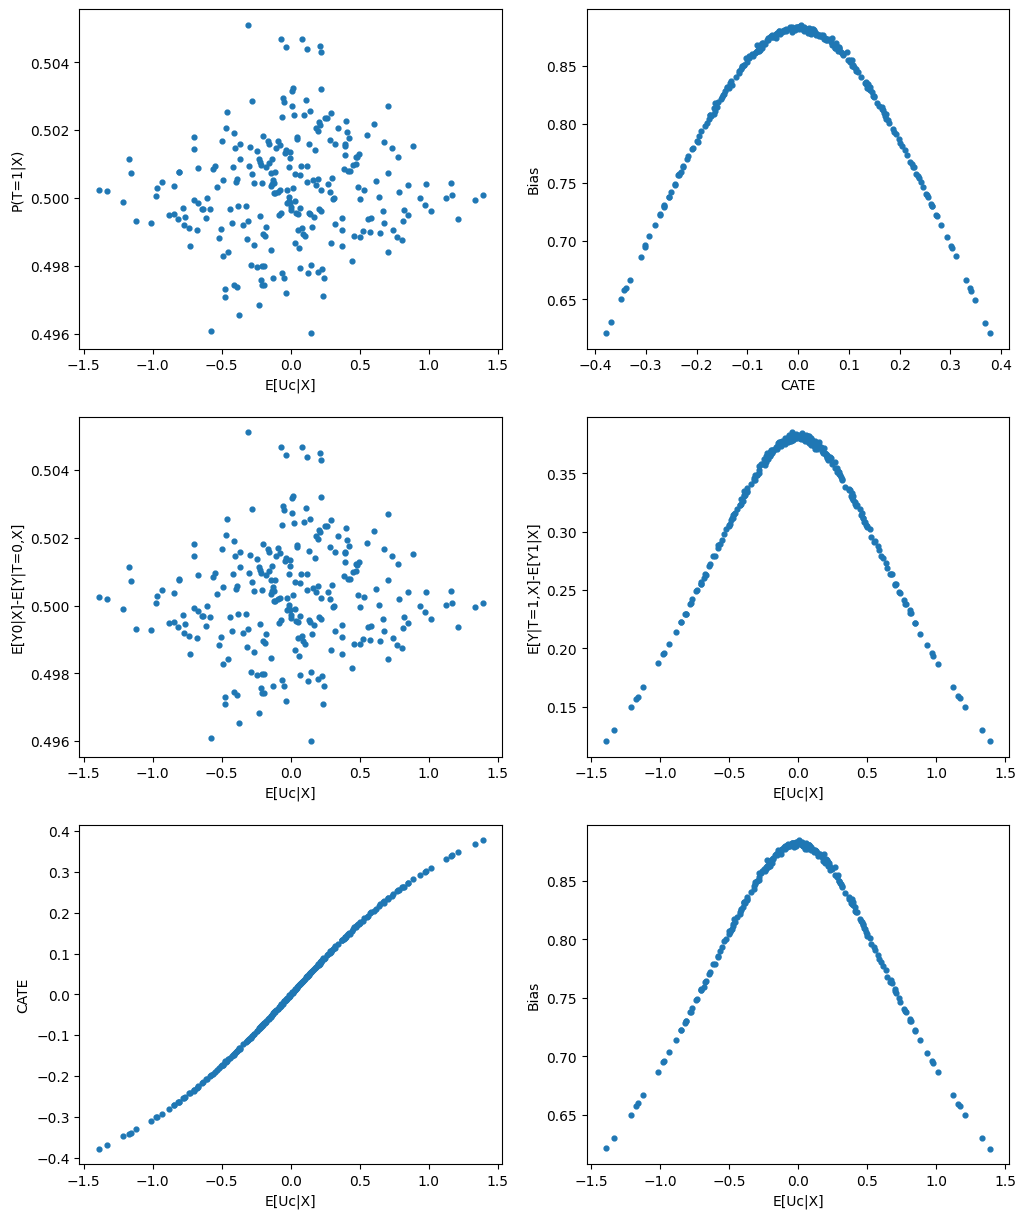

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))
scatter_plot(stats['cauc'], stats['cat'], 'E[Uc|X]', 'P(T=1|X)', ax[0][0])
scatter_plot(stats['cate'], stats['bias'], 'CATE', 'Bias', ax[0][1])
scatter_plot(stats['cauc'], stats['cay0']-stats['cayc'], 'E[Uc|X]', 'E[Y0|X]-E[Y|T=0,X]', ax[1][0])
scatter_plot(stats['cauc'], stats['cayt']-stats['cay1'], 'E[Uc|X]', 'E[Y|T=1,X]-E[Y1|X]', ax[1][1])
scatter_plot(stats['cauc'], stats['cate'], 'E[Uc|X]', 'CATE', ax[2][0])
scatter_plot(stats['cauc'], stats['bias'], 'E[Uc|X]', 'Bias', ax[2][1])

plt.show()

Both $X$ and $U_t$ are related to $U_c$.
```
    Ut
     |
Uy  Uc
     |
     X
```

- Larger $E[U_c|X]$, larger $P(T=1|X)$.
- $E[Y_0|X]-E[Y|T=0,X]$ is close to 0 regardless of X.
- Larger $E[U_c|X]$, smaller $E[Y|T=1,X]-E[Y^1|X]$.
- The bias decreases as the CATE increases.


In [18]:
start = time()
dg.uyct_mean=[0.0, 0.0, 0]
dg.uyct_cov = [
    [1, 0, 0], 
    [0, 1, 1], 
    [0, 1, 1]
]
dg.coef_cov = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]


dg.reset_coef()

repeat = 20
stats = dgp_stats(dg,  n=2000000, seed=0)
for i in range(1, repeat):
    stats += dgp_stats(dg,  n=2000000, seed=i)
stats /= repeat

print(f"Runtime={(time()-start):.3f}s")



Runtime=44.708s


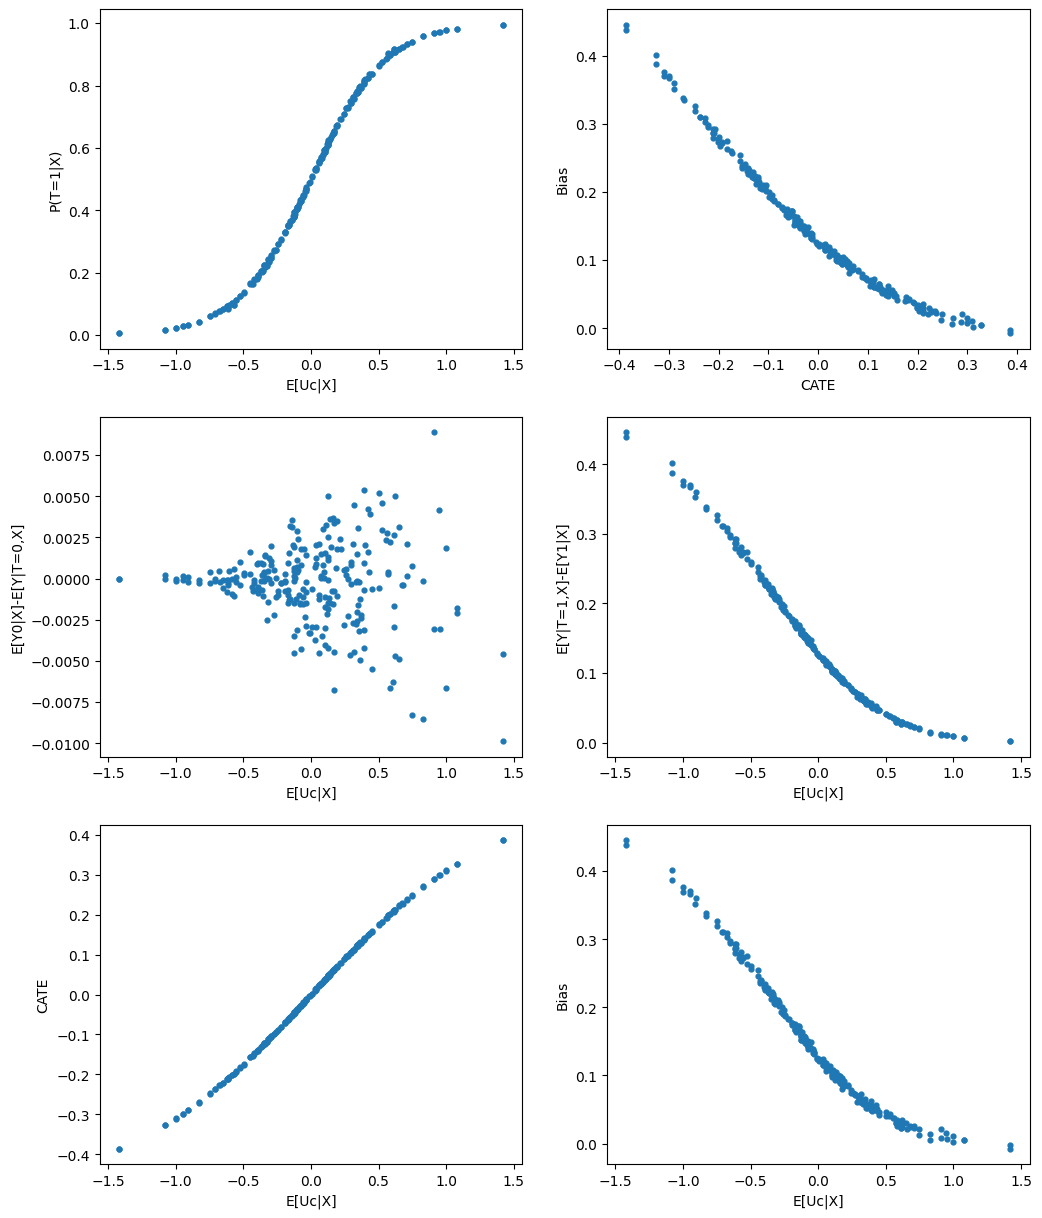

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))
scatter_plot(stats['cauc'], stats['cat'], 'E[Uc|X]', 'P(T=1|X)', ax[0][0])
scatter_plot(stats['cate'], stats['bias'], 'CATE', 'Bias', ax[0][1])
scatter_plot(stats['cauc'], stats['cay0']-stats['cayc'], 'E[Uc|X]', 'E[Y0|X]-E[Y|T=0,X]', ax[1][0])
scatter_plot(stats['cauc'], stats['cayt']-stats['cay1'], 'E[Uc|X]', 'E[Y|T=1,X]-E[Y1|X]', ax[1][1])
scatter_plot(stats['cauc'], stats['cate'], 'E[Uc|X]', 'CATE', ax[2][0])
scatter_plot(stats['cauc'], stats['bias'], 'E[Uc|X]', 'Bias', ax[2][1])

plt.show()